In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import json
import os
import joblib
from matplotlib import colors

from cell_inference.config import paths, params
from cell_inference.utils.transform.geometry_transformation import unitsphere2hphi, trivarnorm2unitsphere
from cell_inference.utils.feature_extractors.SummaryStats2D import scaled_stats_indices
from cell_inference.utils.data_manager import NpzFilesCollector

%matplotlib inline

TRIAL_NAME = 'Reduced_Order_stochastic_spkwid_trunkLR4_LactvCa_Loc3_h1_sumstats7'

## Load data

#### In vivo data

In [2]:
invivo_name = 'all_cell_LFP2D_Analysis_SensorimotorSpikeWaveforms_NP_SUTempFilter_NPExample_v2'
# invivo_name = 'all_cell_LFP2D_Analysis_SensorimotorSpikes_NPUnits_large.h5'

INVIVO_PATH = os.path.join(paths.INVIVO_DATA_PATH, invivo_name)
INVIVO_DATA_PATH = os.path.join(INVIVO_PATH, invivo_name + '.h5')
INVIVO_LFP_PATH = os.path.join(INVIVO_PATH, 'lfp_' + invivo_name + '.npz')  # LFP and labels
INVIVO_STATS_PATH = os.path.join(INVIVO_PATH, 'summ_stats_' + invivo_name + '.npz')  # summary statistics
INVIVO_FEATURE_PATH = os.path.join(INVIVO_PATH, 'features_' + invivo_name + '.csv')  # in vivo data features

with h5py.File(INVIVO_DATA_PATH,'r') as hf, np.load(INVIVO_LFP_PATH) as INVIVO_LFP:
    IDs = hf['ID'][()][INVIVO_LFP['good_indices']]

with np.load(INVIVO_STATS_PATH) as INVIVO_STATS:
    invivo_stats = INVIVO_STATS['x']
    layer = INVIVO_STATS['layer'] # use cortical layers as labels
#     layer = INVIVO_STATS['class_'] # use cell classes as labels
    y_c = INVIVO_STATS['yc']

layer_idx = {L: layer==L for L in np.unique(layer)}
sort_idx = np.argsort(list(layer_idx.keys()))
layer_idx = dict(zip(np.asarray(list(layer_idx))[sort_idx], np.asarray(list(layer_idx.values()))[sort_idx]))
layer_names = list(layer_idx)
nlayers = len(layer_names)
layer_clr = np.array([['lightcyan', 'mistyrose', 'lemonchiffon'], ['darkcyan', 'darkred', 'goldenrod']]).T[:nlayers]
layer_indices = np.array(list(layer_idx.values()))

#### Simulation data

In [3]:
DATA_PATH = paths.SIMULATED_DATA_PATH
TRIAL_PATH = os.path.join(DATA_PATH, TRIAL_NAME)

STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats.npz')  # summary statistics
try:
    STATS = np.load(STATS_PATH)
except:
    STATS = NpzFilesCollector(STATS_PATH)
with STATS:
    sim_stats = STATS['x']

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')  # trial configuration
with open(CONFIG_PATH, 'r') as f:
    config_dict = json.load(f)

inference_list = config_dict['Trial_Parameters']['inference_list']
ranges = config_dict['Simulation_Parameters']['loc_param_range'].copy()
ranges.update(config_dict['Simulation_Parameters']['geo_param_range'])

print(inference_list)

def load_rf_model(model_name):
    """Model name format: input_name_xxx-output_name_yyy-zzz (joined by '-')"""
    name_comps = model_name.split('-')
    in_name, out_name = name_comps[:2]
    MODEL_PATH = os.path.join(TRIAL_PATH, 'RandomForestAnalysis')
    PARAM_PATH = os.path.join(MODEL_PATH, model_name + '.joblib')
    IN_LIST_PATH = os.path.join(MODEL_PATH, in_name + '_in.txt')
    OUT_LIST_PATH = os.path.join(MODEL_PATH, out_name + '_out.txt')
    model = joblib.load(PARAM_PATH)
    feat_ids = np.loadtxt(IN_LIST_PATH, dtype=int)
    with open(OUT_LIST_PATH, 'r') as f:
        label_list = f.read().splitlines()
    return model, feat_ids, label_list

['y', 'd', 'theta', 'l_t', 'lr_pt', 'r_t', 'rr_dt']


### Transform labels

#### Orientation

In [4]:
check_orient = 'h' in inference_list and 'phi' in inference_list
if check_orient:
    orient_idx0 = [inference_list.index(x) for x in ['h', 'phi']]
#     orient_idx2 = orient_idx0.copy()

direction_vec = True # represent orientation by vector on unit sphere
direction_vec = direction_vec and check_orient

label_list = inference_list.copy()
if direction_vec:
    orient_idx1 = list(range(len(inference_list) - 2, len(inference_list) + 1))
#     orient_idx2 = [orient_idx1[1], len(inference_list) + 1]
    label_list.remove('h')
    label_list.remove('phi')
    label_list += ['vx', 'vy', 'vz']
    for i in orient_idx1:
        ranges[label_list[i]] = [-1., 1.]

display_list = label_list.copy()
if direction_vec:
    display_list[orient_idx1[1]] = 'vy / h'
    display_list.append('phi')

#### y shift

In [5]:
has_yshift = 'y' in label_list
if has_yshift:
    ys_idx = label_list.index('y')
    label_list[ys_idx] = 'ys'
    display_list[display_list.index('y')] = 'y-shift'
    ranges['ys'] = [-150, 150] # set bound for normalization

#### Normalization

In [6]:
feature_range = (-1, 1)
norm_scale = lambda x, r: (x - r[0]) / (r[1] - r[0]) * (feature_range[1] - feature_range[0]) + feature_range[0]
org_scale = lambda x, r: (x - feature_range[0]) / (feature_range[1] - feature_range[0]) *  (r[1] - r[0]) + r[0]

### Get magnitude distribution

In [7]:
scaled_idx = scaled_stats_indices()
max_mag_idx = [33, 38]
max_mag = np.amax(sim_stats[:, max_mag_idx], axis=1)
max_mag_invivo = np.amax(invivo_stats[:, max_mag_idx], axis=1)
mag_scale = np.mean(max_mag) / np.mean(max_mag_invivo)
invivo_stats_scaled = invivo_stats.copy()
invivo_stats_scaled[:, scaled_idx] *= mag_scale
print(mag_scale)

0.03336593132117352


## Load model

In [8]:
# 'all', 'morph', 'l_t', 'lr_pt', 'r_t', 'rr_dt'
MODEL_NAME = 'stats_8_24__56_68__72_84-morph'
model, summ_stats_id, select_label = load_rf_model(MODEL_NAME)

### Predict on in vivo data

In [9]:
pred = model.predict(invivo_stats_scaled[:, summ_stats_id]).reshape(-1, len(select_label))

for i, lb in enumerate(select_label):
    pred[:, i] = org_scale(pred[:, i], ranges[lb])
pred_list = select_label.copy()
if 'ys' in select_label:
    ys_idx = select_label.index('ys')
    pred[:, ys_idx] = y_c - pred[:, ys_idx]
    pred_list[ys_idx] = 'y'
if {'vx', 'vy', 'vz'}.issubset(set(select_label)):
    orient_idx1 = [select_label.index(v) for v in ['vx', 'vy', 'vz']]
    pred[:, orient_idx1] = trivarnorm2unitsphere(pred[:, orient_idx1])
    pred = np.hstack([pred, unitsphere2hphi(pred[:, orient_idx1])[:, [1]]])
    pred_list[pred_list.index('vy')] = 'h'
    pred_list.append('phi')
pred_dict = dict(zip(pred_list, pred.T))
pred_dict['layer'] = layer

df_pred = pd.DataFrame(pred_dict, index=IDs)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    if 'y' in df_pred:
        display(df_pred.sort_values(by='y'))
    else:
        pred_dict['y'] = y_c
        df_pred['y'] = y_c
        display(df_pred.sort_values(by='y'))

,l_t,lr_pt,r_t,rr_dt,layer,y
494,751.874180,0.162694,0.671957,0.549063,Layer6,-910.0
457,786.892640,0.185317,0.671262,0.572331,Layer6,-910.0
68,930.875111,0.189301,0.589655,0.644371,Layer6,-890.0
395,795.703495,0.201907,0.569243,0.597594,Layer6,-890.0
396,675.649677,0.216254,0.763334,0.668966,Layer6,-870.0
70,830.196230,0.194002,0.536818,0.630851,Layer6,-870.0
497,672.797223,0.201370,0.648161,0.593889,Layer6,-870.0
500,747.586241,0.229241,0.568641,0.575407,Layer6,-870.0
398,919.852382,0.228560,0.539060,0.581989,Layer6,-870.0
496,759.947299,0.127738,0.681079,0.606432,Layer6,-870.0


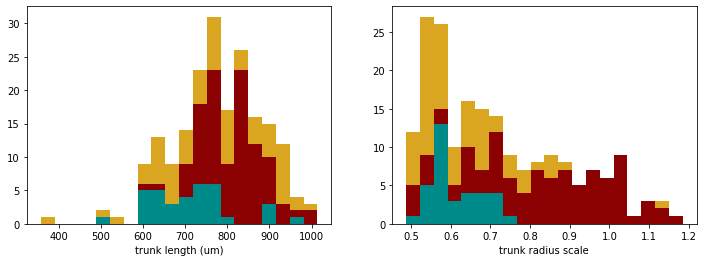

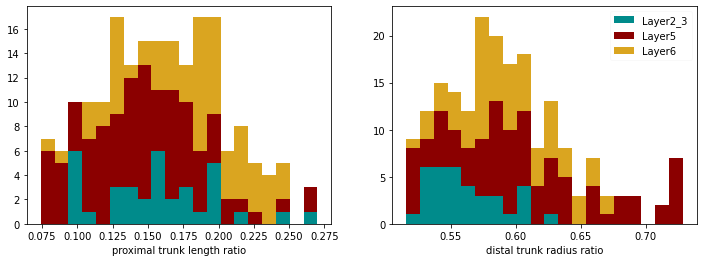

In [10]:
if 'l_t' in select_label or 'r_t' in select_label:
    plt.figure(figsize=(12, 4))
    if 'l_t' in select_label:
        plt.subplot(121)
        plt.hist([pred_dict['l_t'][idx] for idx in layer_indices],
                 bins=20, stacked=True, color=layer_clr[:, 1], label=layer_names)
        plt.xlabel('trunk length (um)')
    if 'r_t' in select_label:
        plt.subplot(122)
        plt.hist([pred_dict['r_t'][idx] for idx in layer_indices],
                 bins=20, stacked=True, color=layer_clr[:, 1], label=layer_names)
        plt.xlabel('trunk radius scale')

if 'lr_pt' in select_label or 'rr_dt' in select_label:
    plt.figure(figsize=(12, 4))
    if 'lr_pt' in select_label:
        plt.subplot(121)
        plt.hist([pred_dict['lr_pt'][idx] for idx in layer_indices],
             bins=20, stacked=True, color=layer_clr[:, 1], label=layer_names)
        plt.xlabel('proximal trunk length ratio')
    if 'rr_dt' in select_label:
        plt.subplot(122)
        plt.hist([pred_dict['rr_dt'][idx] for idx in layer_indices],
             bins=20, stacked=True, color=layer_clr[:, 1], label=layer_names)
        plt.xlabel('distal trunk radius ratio')

plt.legend(framealpha=0.1)
plt.show()

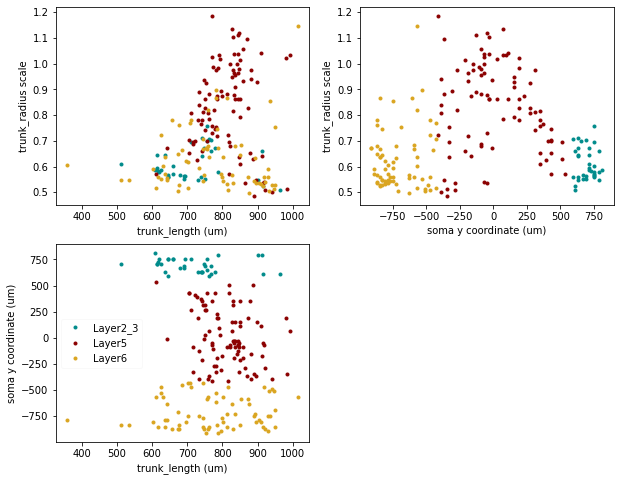

In [11]:
if 'l_t' in select_label and 'r_t' in select_label:
    plt.figure(figsize=(10, 8))
    for i in range(nlayers):
        idx = layer_indices[i]
        if np.count_nonzero(idx) == 0:
            continue
        plt.subplot(221)
        plt.plot(pred_dict['l_t'][idx], pred_dict['r_t'][idx],
                 marker='.', linestyle='None', color=layer_clr[i, 1], label=layer_names[i])
        plt.subplot(222)
        plt.plot(pred_dict['y'][idx], pred_dict['r_t'][idx],
                 marker='.', linestyle='None', color=layer_clr[i, 1], label=layer_names[i])
        plt.subplot(223)
        plt.plot(pred_dict['l_t'][idx], pred_dict['y'][idx],
                 marker='.', linestyle='None', color=layer_clr[i, 1], label=layer_names[i])
    plt.subplot(221)
    plt.xlabel('trunk_length (um)')
    plt.ylabel('trunk_radius scale')
    plt.subplot(222)
    plt.xlabel('soma y coordinate (um)')
    plt.ylabel('trunk_radius scale')
    plt.subplot(223)
    plt.xlabel('trunk_length (um)')
    plt.ylabel('soma y coordinate (um)')
    plt.legend(framealpha=0.1)
    plt.show()

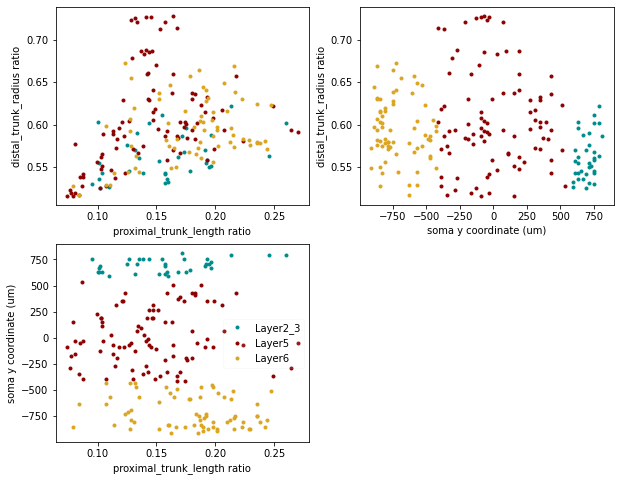

In [12]:
if 'lr_pt' in select_label and 'rr_dt' in select_label:
    plt.figure(figsize=(10, 8))
    for i in range(nlayers):
        idx = layer_indices[i]
        if np.count_nonzero(idx) == 0:
            continue
        plt.subplot(221)
        plt.plot(pred_dict['lr_pt'][idx], pred_dict['rr_dt'][idx],
                 marker='.', linestyle='None', color=layer_clr[i, 1], label=layer_names[i])
        plt.subplot(222)
        plt.plot(pred_dict['y'][idx], pred_dict['rr_dt'][idx],
                 marker='.', linestyle='None', color=layer_clr[i, 1], label=layer_names[i])
        plt.subplot(223)
        plt.plot(pred_dict['lr_pt'][idx], pred_dict['y'][idx],
                 marker='.', linestyle='None', color=layer_clr[i, 1], label=layer_names[i])
    plt.subplot(221)
    plt.xlabel('proximal_trunk_length ratio')
    plt.ylabel('distal_trunk_radius ratio')
    plt.subplot(222)
    plt.xlabel('soma y coordinate (um)')
    plt.ylabel('distal_trunk_radius ratio')
    plt.subplot(223)
    plt.xlabel('proximal_trunk_length ratio')
    plt.ylabel('soma y coordinate (um)')
    plt.legend(framealpha=0.1)
    plt.show()

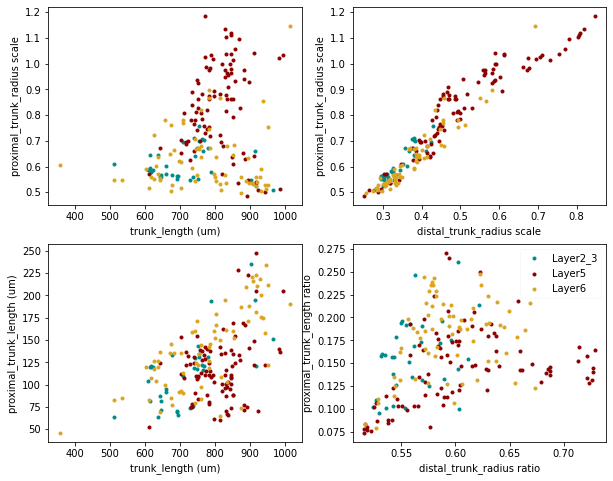

In [13]:
if 'lr_pt' in select_label and 'rr_dt' in select_label:
    plt.figure(figsize=(10, 8))
    for i in range(nlayers):
        idx = layer_indices[i]
        if np.count_nonzero(idx) == 0:
            continue
        plt.subplot(221)
        plt.plot(pred_dict['l_t'][idx], pred_dict['r_t'][idx],
                 marker='.', linestyle='None', color=layer_clr[i, 1], label=layer_names[i])
        plt.subplot(222)
        plt.plot(pred_dict['rr_dt'][idx] * pred_dict['r_t'][idx], pred_dict['r_t'][idx],
                 marker='.', linestyle='None', color=layer_clr[i, 1], label=layer_names[i])
        plt.subplot(223)
        plt.plot(pred_dict['l_t'][idx], pred_dict['lr_pt'][idx] * pred_dict['l_t'][idx],
                 marker='.', linestyle='None', color=layer_clr[i, 1], label=layer_names[i])
        plt.subplot(224)
        plt.plot(pred_dict['rr_dt'][idx], pred_dict['lr_pt'][idx],
                 marker='.', linestyle='None', color=layer_clr[i, 1], label=layer_names[i])
    plt.subplot(221)
    plt.xlabel('trunk_length (um)')
    plt.ylabel('proximal_trunk_radius scale')
    plt.subplot(222)
    plt.xlabel('distal_trunk_radius scale')
    plt.ylabel('proximal_trunk_radius scale')
    plt.subplot(223)
    plt.xlabel('trunk_length (um)')
    plt.ylabel('proximal_trunk_length (um)')
    plt.subplot(224)
    plt.xlabel('distal_trunk_radius ratio')
    plt.ylabel('proximal_trunk_length ratio')
    plt.legend(framealpha=0.1)
    plt.show()